In [25]:
from obspy.core import Stream, read
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path


In [56]:
path = '/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/'
snr_array = pd.read_csv(path + 'stations_hypdists_snrs.list')
snr_array

,Station_name,latitude,longitude,azimuth(S1),azimuth(S2),azimuth(S3),azimuth(S4),hyp_dist_km,rms_snr
0,KST1,33.5201,135.8363,310,40,85,175,792.746765,1.273396
1,HGM1,33.8675,135.7318,337,67,112,202,773.809644,1.139778
2,ICU1,33.9001,136.1379,141,231,276,6,743.491829,1.203692
3,ANO1,34.7870,136.4019,38,128,173,263,661.251185,1.113420
4,SSK1,33.3896,133.3229,355,85,130,220,981.546244,1.285971
5,UWA1,33.3859,132.4823,222,312,357,87,1045.683453,1.282839
6,MUR1,33.2856,134.1563,147,237,282,12,927.200827,1.258307
7,MYM1,34.1123,136.1815,237,327,12,102,724.694237,1.134499


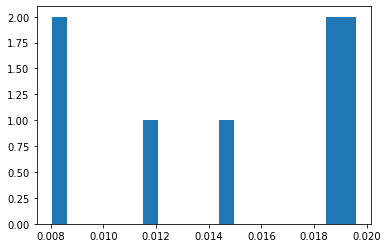

In [57]:
plt.hist(mcmc_results['m1'], bins = 20);

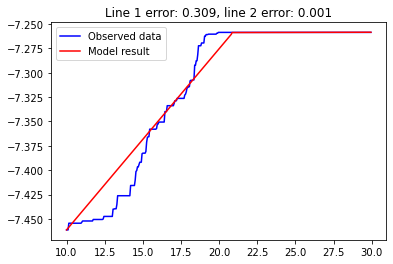

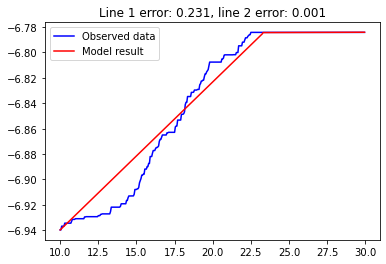

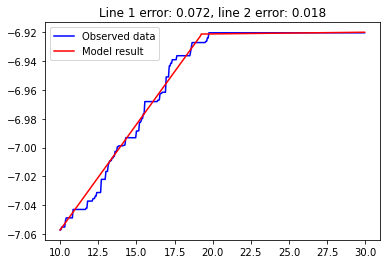

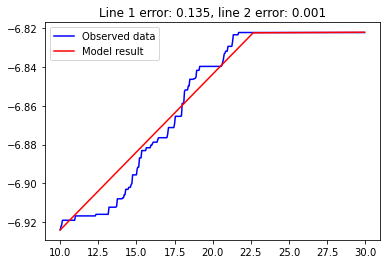

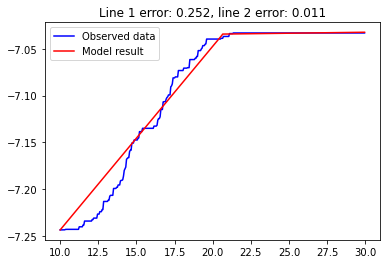

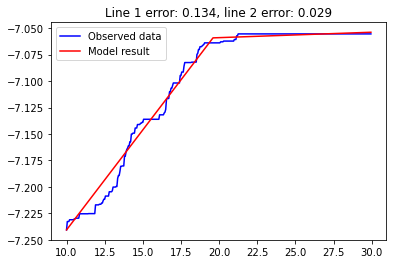

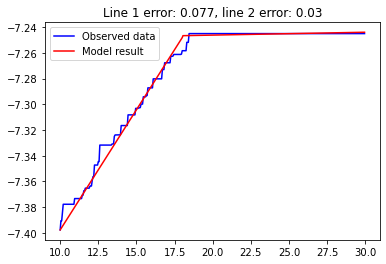

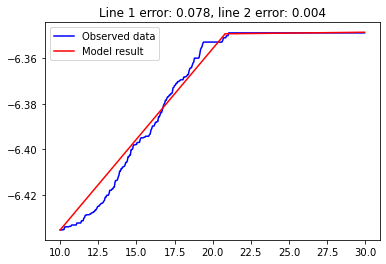

In [58]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path + 'mcmc_arrays/mcmc_results_summary.csv')
mcmc_results_array = mcmc_results.values

counter = 0
results = []

for idx in range(len(mcmc_results_array)):
    
    eq_id = str(mcmc_results_array[idx,0])
    sta = str(mcmc_results_array[idx,2])
    hypdist = int(mcmc_results_array[idx,3])

    # print(eq_id, sta, hypdist)

    # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
    xlow = 10
    xhigh = 30
    
    try:
        # Read in data - peak strain data only has the ones with SNR > 2
        pst = read(path + 'filtered_peak_post_p/' + sta + '.mseed')
        counter += 1
        # pst.plot()
        # plt.plot(pst[0].times(), pst[0].data)
        # plt.semilogy()
        # plt.show()

    except:
        continue # Skips to next row in dist_array/next station

    times = pst[0].times()
    data = pst[0].data
    log10_data = np.log10(data)
    samp_rate = pst[0].stats.sampling_rate
    
    vec_start = int(xlow*samp_rate)
    vec_end = int(xhigh*samp_rate)

    xobserved = times[vec_start:vec_end]
    yobserved = log10_data[vec_start:vec_end]
    x0 = xobserved[0]
    y0 = yobserved[0]
    
    m1_slope = float(mcmc_results_array[idx,5])
    m2_slope = float(mcmc_results_array[idx,6])
    int_time = float(mcmc_results_array[idx,7])
    
    diff = m1_slope - m2_slope
    
    int_x_samp = int(int_time*samp_rate)
    
    # mx + b for the lines
    
    b1 = y0 - m1_slope*x0
    b2 = m1_slope*int_time + b1 - m2_slope*int_time
    
    line1_xobs = times[vec_start:int_x_samp]
    line1_ymodel = m1_slope * line1_xobs + b1
    line1_yobs = log10_data[vec_start:int_x_samp]
    
    line2_xobs = times[int_x_samp:vec_end]
    line2_ymodel = m2_slope * line2_xobs + b2
    line2_yobs = log10_data[int_x_samp:vec_end]
    
    xobs = np.append(line1_xobs, line2_xobs)
    ymodel = np.append(line1_ymodel, line2_ymodel)
    yobs = np.append(line1_yobs, line2_yobs)
    
    error_line1 = np.sqrt(np.sum(np.square(np.subtract(line1_ymodel, line1_yobs))))
    error_line2 = np.sqrt(np.sum(np.square(np.subtract(line2_ymodel, line2_yobs))))
    
    error = np.sqrt(np.sum(np.square(np.subtract(ymodel, yobs))))
    # print(error)
    
    # if error <= 4.9:
    #     results.append('g')
    # else:
    #     results.append('b')
        
    # if diff > 0.1 and error_line1 < 5 and error_line2 < 10 and m2_slope > 0.005:
    if diff > 0 and error_line1 < 3.5 and error_line2 < 6.5:
        results.append('g')
        plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)))
        plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
        plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
        plt.legend()
        plt.show()
    else:
        results.append('b')
        # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)) + '\ndiff: ' + str(round(diff,3)) + ', M2 slope: ' + str(round(m2_slope,4)))
        # plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
        # plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
        # plt.legend()
        # plt.show()

mcmc_results['two_line_fit_qual'] = results
    
    # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)) + '\ndiff: ' + str(round(diff,3)) + ', M2 slope: ' + str(round(m2_slope,4)))
    # plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
    # plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
    # plt.legend()
    # plt.show()

        

In [59]:
mcmc_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,two_line_fit_qual
0,tohoku,9.1,KST1,792,30,0.018605,0.000033,20.896196,0.015566,20.9,g
1,tohoku,9.1,HGM1,773,30,0.011654,0.000040,23.334004,0.011654,23.4,g
2,tohoku,9.1,ICU1,743,30,0.014632,0.000116,19.284806,0.003710,19.3,g
3,tohoku,9.1,ANO1,661,30,0.008050,0.000041,22.650964,0.006772,22.7,g
4,tohoku,9.1,SSK1,981,30,0.019608,0.000211,20.664609,0.012705,20.7,g
5,tohoku,9.1,UWA1,1045,30,0.018896,0.000514,19.607421,0.006886,19.7,g
6,tohoku,9.1,MUR1,927,30,0.018711,0.000224,18.082029,0.004194,18.1,g
7,tohoku,9.1,MYM1,724,30,0.007949,0.000074,20.815360,0.003963,20.9,g


In [60]:
mcmc_results.to_csv(path + 'mcmc_arrays/mcmc_results_summary_with_quality.csv', index = False)

In [61]:
good_results = mcmc_results[mcmc_results['two_line_fit_qual'] == 'g']
bad_results = mcmc_results[mcmc_results['two_line_fit_qual'] == 'b']

bad_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,two_line_fit_qual


In [62]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,9.25,0.05)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

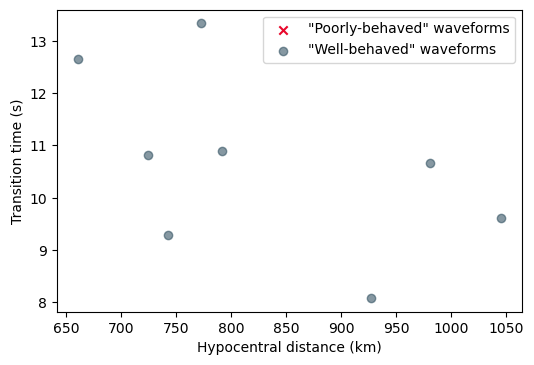

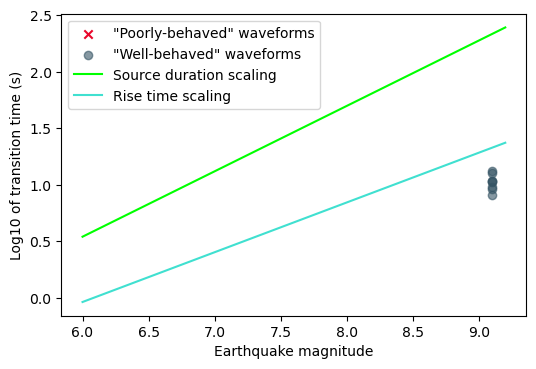

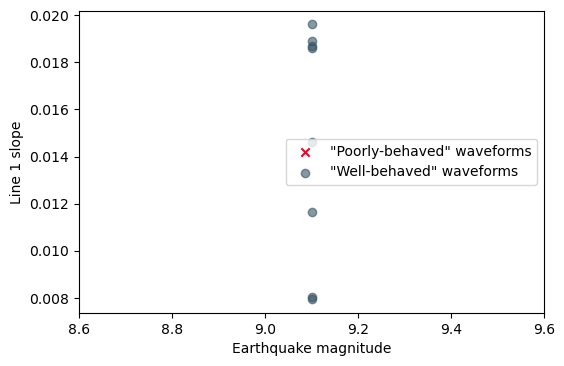

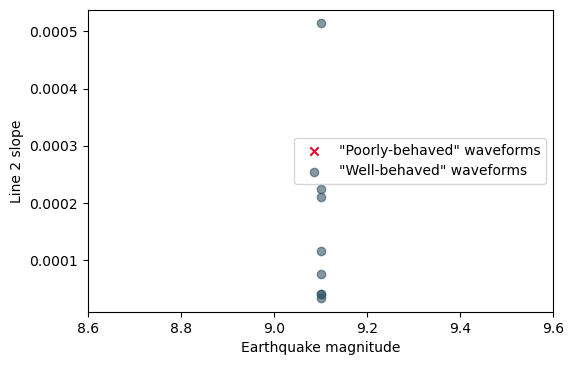

In [63]:
dpi = 100

plt.figure(dpi = dpi)
plt.scatter(bad_results.hypdist.values, bad_results.xinter.values-10, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.hypdist.values, good_results.xinter.values-10, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.xlabel('Hypocentral distance (km)')
plt.ylabel('Transition time (s)')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_hypdist_vs_transtime.png', format = 'PNG')
# plt.close()

plt.figure(dpi = dpi)
plt.scatter(bad_results.mag.values, np.log10(bad_results.xinter.values-10), marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.mag.values, np.log10(good_results.xinter.values-10), marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_transtime.png', format = 'PNG')
# plt.close()

plt.figure(dpi = dpi)
plt.scatter(bad_results.mag.values, bad_results.m1.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.mag.values, good_results.m1.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 1 slope')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_m1.png', format = 'PNG')
# plt.close()

plt.figure(dpi = dpi)
plt.scatter(bad_results.mag.values, bad_results.m2.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.mag.values, good_results.m2.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 2 slope')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_m2.png', format = 'PNG')
# plt.close()